<a href="https://colab.research.google.com/github/Katona-lab/MST-analysis/blob/main/MST_progress_curve_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title STEP 1: Start here by selecting an Excel MST file exported by the Nanotemper software.
#@markdown To activate a step press the Play button on the left. Run the steps sequentially, but chose only one alternative if alternative steps are offered.<p>
#@markdown Please cite this article: <p>
#@markdown Atsarina Larasati Anindya, Maria-Jose Garcia-Bonete, Maja Jensen, Christian V. Recktenwald, Maria Bokarewa and Gergely Katona <i>Bayesian Progress Curve Analysis of MicroScale Thermophoresis Data.</i>
#@markdown (2022) <b><i>Digital discovery</i></b><p>
#@markdown https://doi.org/10.1039/D1DD00026H
# (c) 2022 Gergely Katona <gergely.katona@gu.se>
import io
import pandas as pd
from google.colab import files
import numpy as np
import pymc3 as pm
import pylab as plt
import theano.tensor as T
from pymc3.math import switch

#Experimental data description 
uploaded = files.upload()

df=pd.read_excel(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

ligpos=df.loc[df.iloc[:,0] == 'Ligand Concentration:'].index[0]
firsttimepos=df.loc[df.iloc[:,0] == 'Time [s]'].index[0]
targind=df.loc[df.iloc[:,0] == 'TargetConcentration:'].index[0]
FluoConc=df.iloc[targind,1]

cideal=df.iloc[ligpos,1::3]
onedtime=df.iloc[firsttimepos+1:,0].reset_index(drop=True)
firstIRtimepos=onedtime.loc[onedtime==0].index[0]
fluorescence=df.iloc[firsttimepos+1:,1::3].reset_index(drop=True)
fluorescence=fluorescence.T.reset_index(drop=True).T
Capillary=len(cideal)
start_t=onedtime.iloc[0]
end_t=onedtime.iloc[-1]
print ("The data starts at position %i, which corresponds to %f s." % (0,start_t))
print ("The data ends at position %i, which corresponds to %f s." % (len(onedtime),end_t))
print ("The IR laser is supposed to be ON from position %i, which corresponds to 0 s."% (firstIRtimepos))
print ("The target concentration is %E ."% FluoConc)
if FluoConc < 1:
  print ("I guess you are using units of M?")
if FluoConc > 1:
  print ("I guess you are using units of nM?")
print ("%i capillaries were used." % Capillary)
print ("The ligand concentrations are %s . "% list(cideal))
print ("Units hopefully are in nM (due to the numerical limits of KD prior) and the KD will be expressed in the same unit. If these concentrations are invalid, please edit them in the input excel file.")

Saving MSTTraces_Sgo2_run1.xlsx to MSTTraces_Sgo2_run1.xlsx
The data starts at position 0, which corresponds to -5.514154 s.
The data ends at position 543, which corresponds to 34.947815 s.
The IR laser is supposed to be ON from position 73, which corresponds to 0 s.
The target concentration is 2.000000E+01 .
I guess you are using units of nM?
16 capillaries were used.
The ligand concentrations are [500000, 250000, 125000, 62500, 31250, 15625, 7812.5, 3906.25, 1953.125, 976.5625, 488.2813, 244.1406, 122.0703, 61.0352, 30.5176, 15.2588] . 
Units hopefully are in nM (due to the numerical limits of KD prior) and the KD will be expressed in the same unit. If these concentrations are invalid, please edit them in the input excel file.


In [ ]:
#@title STEP 2: Displaying and verifying the data. Adjusting data range and laser start. { run: "auto" }
import ipywidgets as widgets
from IPython.display import display
#@markdown Step 2.1: Inspect the progress curve. Is this the data you want to model? The program tries to guess a suitable end point automatically, by choosing the minimum of Fnorm. This initial guess will vary from capillary to capillary, but once you start modelling the last displayed end data point will be used for for all capillaries. Please feel free to override data range according to your wishes, keep in mind that linear kinetic processes can increase Fnorm after the exponential processes finished and the model has a chance to deal with them. In that case, feel free to extend the data range beyond the time Fnorm reaches the absolute minimum.<p>
#@markdown Step 2.2: Zoom in with the sliders to the laser start point and adjust to the point where the Fnorm starts to drop rapidly. Experience shows that there is a few ms delay between time 0 of the instrument and the first sign of response in Fnorm. An empirical delay is already automatically applied to the laser start.<p>
#@markdown Step 2.3: Reset the end slider to the end of the IR irradiation period or any point earlier. The model does not take into account the recovery phase after the IR laser is swiched off.
Cap_display = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

Data_range=widgets.IntRangeSlider(
    value=[0, fluorescence[int(Capillary)-1].astype(float).idxmin()],
    min=0,
    max=len(onedtime),
    step=1,
    description='Data_range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)


IR_pos=widgets.IntSlider(
    value=firstIRtimepos+2,
    min=0,
    max=len(onedtime),
    step=1,
    description='IR_pos:',
    disabled=False
)

def f(Data_range, IR_pos):
    Start_pos,End_pos=Data_range
    fig, ax = plt.subplots()
    ax.plot(onedtime[Start_pos:End_pos],fluorescence[int(Cap_display)-1].astype(float).iloc[Start_pos:End_pos], color='gray')
    ax.annotate('IR laser', 
            xy=(onedtime[IR_pos], 1), 
            xytext=(onedtime[IR_pos], 0.95), 
            arrowprops = dict(facecolor='red', shrink=0.05)
    )
    plt.xlabel ("Time (s)")
    plt.ylabel (r"$F_{norm}$")
out = widgets.interactive_output(f, {'Data_range': Data_range, 'IR_pos': IR_pos})

widgets.HBox([widgets.VBox([Data_range, IR_pos]), out])



In [ ]:
#@title STEP 3.1 (Alternative 1): Perform the MCMC sampling (linear phase starts before the IR irradiation)
#@markdown Use scenario: The fluroescence signal (Fnorm) is not stable at 1 before IR irradiation. Possible reasons: photodamage, unstable protein, not fully equilibrated target:ligand interaction.

#@markdown Choose the concentration units to provide appropriate prior distribution for K_D.

K_D_prior="informative uniform prior for nM units" #@param ["informative uniform prior for nM units", "informative uniform prior for M units", "flat exponential prior for any unit"]

#@markdown Enter the number of tuning and sampling steps for the Markov Chain Monte Carlo algorithm. Decrease these only if you know what you are doing.
Tuning = 1000 #@param {type:"number"}
Samples = 2000 #@param {type:"number"}

IR=IR_pos.value
start,end=Data_range.value
cap=int(Capillary)
time=np.array([onedtime[:,]]*cap,dtype=float).transpose()
with pm.Model() as model:
    if K_D_prior=="informative uniform prior for nM units":
        K_D = pm.Uniform('K_D', 1, 1e6)
    if K_D_prior=="informative uniform prior for M units":
        K_D = pm.Uniform('K_D', 1e-9, 1e-3)
    if K_D_prior=="flat exponential prior for any unit":
        K_D = pm.Exponential('K_D', 1e-3)
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1e8)
    c_fl = BoundedNormal('c_fl',mu=FluoConc,sd=FluoConc/10.0)

    U=pm.Beta('U',alpha=1,beta=1)
    B=pm.Beta('B',alpha=1,beta=1)
    A_total=pm.Deterministic('A_total', U + (B-U)*((c_fl + cideal.astype(float) + K_D - pm.math.sqrt(pm.math.sqr(c_fl + cideal.astype(float) + K_D) - 4.0*c_fl*cideal.astype(float)))/(2*c_fl)))
    
    L=pm.Uniform('L',-1,1, shape=cap)
    I=pm.Deterministic('I',1+L*start_t-A_total)
    R=pm.Beta('R',alpha=2,beta=1, shape=cap)
    A_1=pm.Deterministic('A_1',A_total*R)
    A_2=pm.Deterministic('A_2',A_total*(1-R))
    rate1=pm.Lognormal('rate1',0,1, shape=cap)
    rate2=pm.Lognormal('rate2',0,1, shape=cap)

    linearphase=L*(time-start_t)
    E_1=A_1*pm.math.exp(-1.0*rate1*time)
    E_2=A_2*pm.math.exp(-1.0*rate2*time)

    epsilon = pm.Lognormal('epsilon', 0, 1)
    laseron=np.tile(np.arange(0, len(onedtime)), (cap,1)).T

    pr = switch(IR >= laseron, 1.0+linearphase, linearphase+I+E_1+E_2)


    P = pm.Normal('P', mu=pr[start:end], sd=epsilon, observed=fluorescence.astype(float).iloc[start:end])


with model:
    trace = pm.sampling.sample(Samples, tune=Tuning,
                      init='ADVI'
                     )
    
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000 ,model=model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 68700
Interrupted at 68,699 [34%]: Average Loss = 1.4272e+13
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, rate2, rate1, R, L, B, U, c_fl, K_D]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1995 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
#@title STEP 3.2 (Alternative 2): Perform the MCMC sampling (linear phase starts at time 0)
#@markdown Use scenario: Fnorm is stable at 1 before IR irradiation, but after irradiation there is a trendlike increase or decrease in at least some of the progress curves. Possible causes: temperature induced denaturation of proteins, direct IR absorption in protein results in an electrodynamic interaction between the target and the ligand.

#@markdown Choose the concentration units to provide appropriate prior distribution for K_D.

K_D_prior="informative uniform prior for nM units" #@param ["informative uniform prior for nM units", "informative uniform prior for M units", "flat exponential prior for any unit"]


#@markdown Enter the number of tuning and sampling steps for the Markov Chain Monte Carlo algorithm. Decrease these only if you know what you are doing.
Tuning = 1000 #@param {type:"number"}
Samples = 2000 #@param {type:"number"}

IR=IR_pos.value
start,end=Data_range.value
cap=int(Capillary)
time=np.array([onedtime[:,]]*cap,dtype=float).transpose()
with pm.Model() as model:
    if K_D_prior=="informative uniform prior for nM units":
        K_D = pm.Uniform('K_D', 1, 1e6)
    if K_D_prior=="informative uniform prior for M units":
        K_D = pm.Uniform('K_D', 1e-9, 1e-3)
    if K_D_prior=="flat exponential prior for any unit":
        K_D = pm.Exponential('K_D', 1e-3)
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1e8)
    c_fl = BoundedNormal('c_fl',mu=FluoConc,sd=FluoConc/10.0)

    U=pm.Beta('U',alpha=1,beta=1)
    B=pm.Beta('B',alpha=1,beta=1)
    A_total=pm.Deterministic('A_total', U + (B-U)*((c_fl + cideal.astype(float) + K_D - pm.math.sqrt(pm.math.sqr(c_fl + cideal.astype(float) + K_D) - 4.0*c_fl*cideal.astype(float)))/(2*c_fl)))
    
    L=pm.Uniform('L',-1,1, shape=cap)
    I=pm.Deterministic('I',1-A_total)
    R=pm.Beta('R',alpha=2,beta=1, shape=cap)
    A_1=pm.Deterministic('A_1',A_total*R)
    A_2=pm.Deterministic('A_2',A_total*(1-R))
    rate1=pm.Lognormal('rate1',0,1, shape=cap)
    rate2=pm.Lognormal('rate2',0,1, shape=cap)

    linearphase=L*(time)
    E_1=A_1*pm.math.exp(-1.0*rate1*time)
    E_2=A_2*pm.math.exp(-1.0*rate2*time)

    epsilon = pm.Lognormal('epsilon', 0, 1)
    laseron=np.tile(np.arange(0, len(onedtime)), (cap,1)).T

    pr = switch(IR >= laseron, 1.0, linearphase+I+E_1+E_2)


    P = pm.Normal('P', mu=pr[start:end], sd=epsilon, observed=fluorescence.astype(float).iloc[start:end])
  
with model:
    trace = pm.sampling.sample(Samples, tune=Tuning,
                      init='ADVI'
                     )
    
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000 ,model=model)

In [ ]:
#@title STEP 4: Statistics of global variables
#@markdown If you are finished with Step 1-3, the later steps do not have to follow in strict order. <p>
#@markdown K_D and c_fl units are traditionally expressed in nM in the Nanotemper software, U, B and epsilon are expressed as Fnorm.  
pm.stats.summary(trace,var_names=['K_D','B','U', 'epsilon','c_fl'])


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K_D,1822.711,183.243,1477.747,2149.699,6.942,4.911,687.0,1545.0,1.0
B,0.279,0.000,0.279,0.280,0.000,0.000,996.0,1905.0,1.0
U,0.252,0.000,0.251,0.253,0.000,0.000,345.0,839.0,1.0
epsilon,0.001,0.000,0.001,0.001,0.000,0.000,6064.0,2386.0,1.0
c_fl,20.002,2.076,16.152,23.965,0.022,0.016,8751.0,2743.0,1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


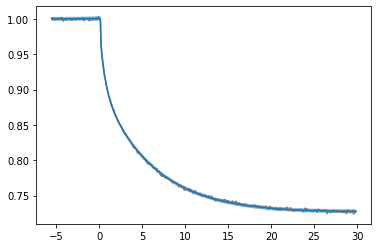

In [ ]:
#@title STEP 5: Posterior predictive check { run: "auto" }
#@markdown The shaded area represent the High Density Interval (95%) of the posterior predictions.
#@markdown <p> Choose the capillary to analyse:
Cap_display = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

plt.plot(onedtime[start:end],fluorescence[int(Cap_display)-1].astype(float).iloc[start:end], color='gray')
plt.plot(onedtime[start:end],np.mean(ppc['P'][:,:,int(Cap_display)-1], axis=0))
plt.fill_between(np.array(onedtime[start:end],dtype=float), np.array(pm.stats.hdi(ppc['P'][:,:,int(Cap_display)-1])[:,0],dtype=float) ,np.array(pm.stats.hdi(ppc['P'][:,:,int(Cap_display)-1])[:,1],dtype=float) , alpha=0.5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


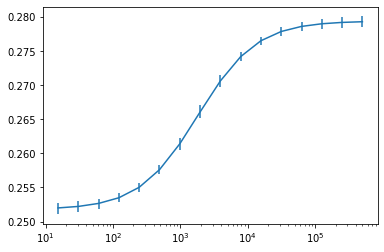

In [ ]:
#@title STEP 6: Concentration dependence of the kinetic parameters. { run: "auto" }
#@markdown The error bars represent the High Density Interval (95%) of the posterior distribution.<p>
#@markdown Choose the variable name:
parameter = "A_total" #@param ["A_total","I", "rate1", "rate2", "A_1", "A_2", "L"]
fig=plt.subplot(111)
plt.errorbar(cideal,np.median(trace[parameter],axis=0),yerr=np.abs(pm.hdi(trace[parameter]).T-np.median(trace[parameter],axis=0)))
fig.set_xscale('log')

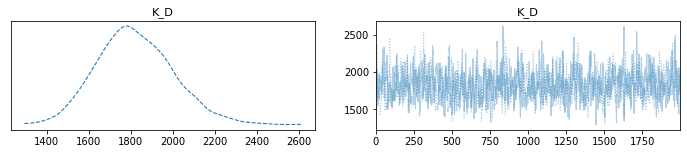

In [ ]:
#@title STEP 7: Posterior distribution of model parameters (left), parameter trace (right). { run: "auto" }
#@markdown Ideally the parameter traces fluctuate around a stable value.<p> 
#@markdown Choose the parameter name:
parameter = "K_D" #@param ["K_D","B","U","epsilon","A_total","I", "rate1", "rate2", "A_1", "A_2", "L"]
with model:
  ax=pm.plot_trace(trace[0:],[parameter],combined=True)